In [1]:
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.express as px
import plotly.figure_factory as ff
import urllib, json
import random

from plotters.data_generators import create_site_data

In [7]:
#https://medium.com/@enigma.pythonml/how-to-create-sankey-diagrams-from-data-frames-in-python-plotly-and-kaggles-titanic-data-1f7d56b28096
#https://zebrabi.com/guide/how-to-customize-sankey-diagram-in-python-matplotlib/
#https://python-graph-gallery.com/sankey-diagram-with-python-and-plotly/

In [4]:
years=list(range(2020, 2051))
first_df = create_site_data(years = years)
first_df['Total'] = first_df.loc[:, [f'Year_{year}' for year in years]].sum(axis=1)

In [7]:
# Select columns that aren't years
subset_columns = ['program1', 'program2', 'program3', 'program4', 'Total']

# Create a new DataFrame with the selected columns
df = first_df.loc[:, subset_columns]

# Display the new DataFrame
df.head()

program1 program2 program3 program4  Total
0    site3  site7.1  site4.2             211
1    site4  site2.1  site7.2  site3.3    340
2    site1  site2.1  site3.2  site3.3    249
3    site3  site4.1  site6.2  site3.3    384
4    site3  site2.1  site2.2  site4.3    119

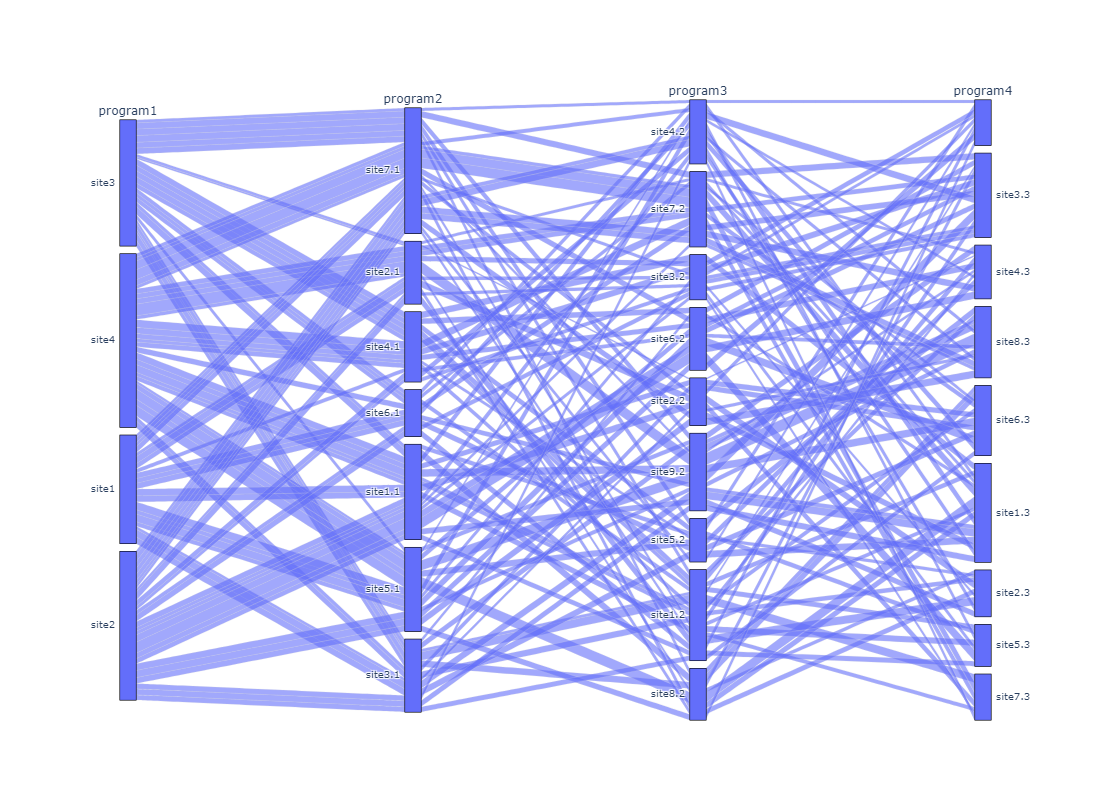

In [8]:
fig = go.Figure(go.Parcats(
    dimensions=[
        {'label': 'program1', 'values': df['program1']},
        {'label': 'program2', 'values': df['program2']},
        {'label': 'program3', 'values': df['program3']},
        {'label': 'program4', 'values': df['program4']}
    ],
    counts=df['Total'],
))
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)

fig.show()

In [9]:
def create_sankey(df):
    """
    We need three loops:
    program1 -> program2
    program2 -> program3
    program3 -> program4
    """
    
    program1 = df["program1"].unique().tolist()
    program2 = df["program2"].unique().tolist()
    program3 = df["program3"].unique().tolist()
    program4 = df["program4"].unique().tolist()
    
    labels = program1 + program2 + program3 + program4
    
    sources = []
    targets = []
    values = []
    
    for prog1 in program1:
        for prog2 in program2:
            df1 = df.loc[df["program1"] == prog1]
            total = df1.loc[df["program2"] == prog2,"Total"].sum()
            sources.append(labels.index(prog1))
            targets.append(labels.index(prog2))
            values.append(total)
    
    for prog2 in program2:
        for prog3 in program3:
            df1 = df.loc[df["program2"] == prog2]
            total = df1.loc[df["program3"] == prog3,"Total"].sum()
            sources.append(labels.index(prog2))
            targets.append(labels.index(prog3))
            values.append(total)
    
    for prog3 in program3:
        for prog4 in program4:
            df1 = df.loc[df["program3"] == prog3]
            total = df1.loc[df["program4"] == prog4,"Total"].sum()
            sources.append(labels.index(prog3))
            targets.append(labels.index(prog4))
            values.append(total)

    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = labels,
          color = "blue"
        ),
        link = dict(
          source = sources,
          target = targets,
          value = values
      ))])
    
    fig.update_layout(title_text="Flow", font_size=10)
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
    )
    fig.show()

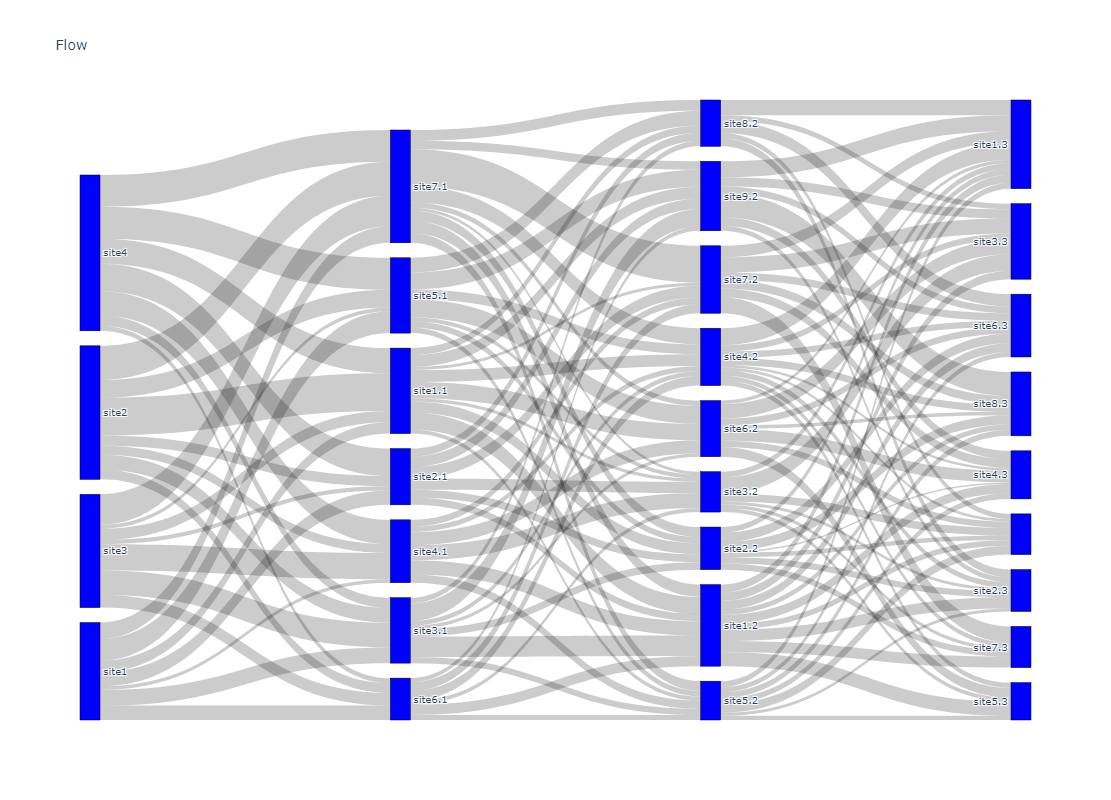

In [10]:
create_sankey(df)

## Arc Plot
- Arc plots are difficult to create with plotly
- You have to implement a custom solution
- Data must be in format found here:
- https://github.com/evelinag/StarWars-social-network/blob/master/networks/starwars-episode-7-interactions-allCharacters.json
- https://github.com/evelinag/StarWars-social-network/tree/master/networks
- https://lvngd.com/blog/arc-diagrams-d3js-data-preparation/

## Network Plot

In [11]:
import plotly.graph_objects as go
import networkx as nx
import gravis as gv
# For 3D networks: https://plotly.com/python/v3/3d-network-graph/

In [16]:
df.head()

program1 program2 program3 program4  Total
0    site3  site7.1  site4.2            2309
1    site4  site2.1  site7.2  site3.3   2136
2    site1  site2.1  site3.2  site3.3   2273
3    site3  site4.1  site6.2  site3.3   2272
4    site3  site2.1  site2.2  site4.3   2305

In [17]:
def get_combinations(df, subset_columns = ['program1', 'program2', 'program3', 'program4']):    
    # Create a new DataFrame with the selected columns
    df1 = df.loc[:, subset_columns]
    combinations = []
    for idx, row in df1.iterrows():
        # Replace None with "Not Available"
        rows = row.values.tolist()
        row = ["Not Available" if not value else value for value in rows]
    
        for i in range(len(subset_columns)):  # Iterate over program1 to program4
            for j in range(i + 1, len(subset_columns)):  # Avoid duplicate combinations
                combinations.append((row[i], row[j]))
    return combinations

In [18]:
combinations = get_combinations(df,subset_columns = ['program1', 'program2'])

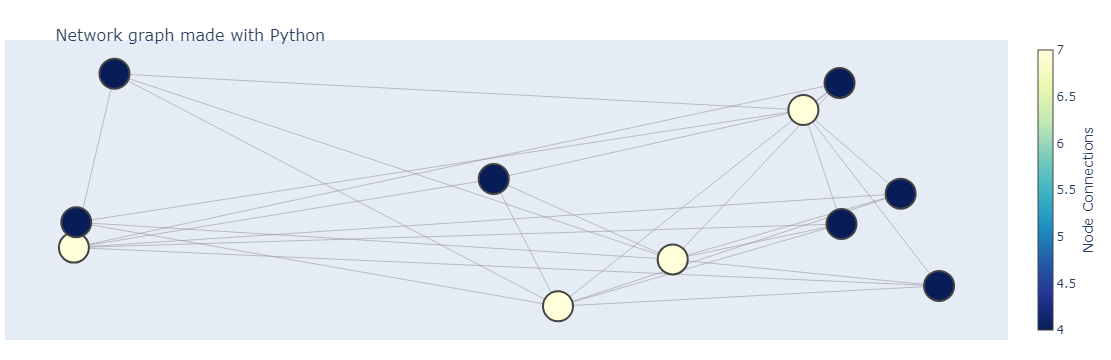

In [19]:
G = nx.Graph()
G.add_edges_from(combinations)
pos = {node: (random.uniform(0, 1), random.uniform(0, 1)) for node in G.nodes()}

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=30,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text


fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

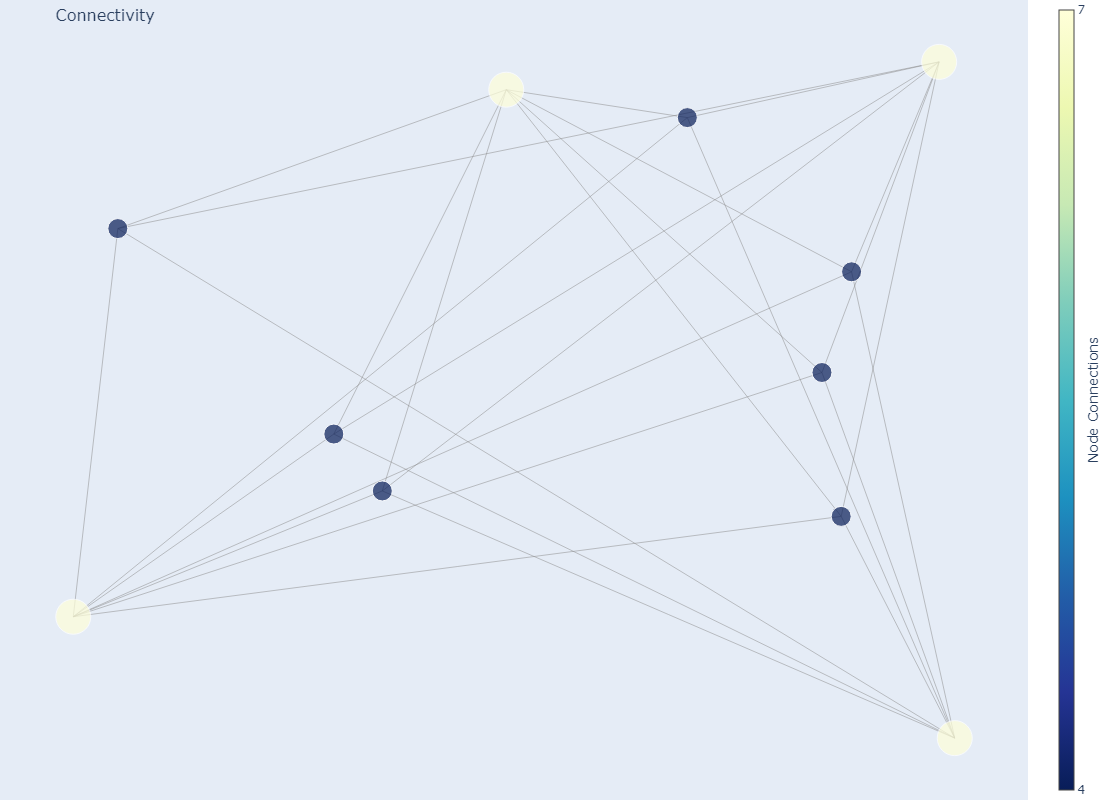

In [20]:
G = nx.Graph()
G.add_edges_from(combinations)

pos = {node: (random.uniform(0, 1), random.uniform(0, 1)) for node in G.nodes()}

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

# Modified node_trace definition
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=500,
        cmin=min(node_adjacencies),
        cmax=max(node_adjacencies),
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right',
            tickvals=[min(node_adjacencies), max(node_adjacencies)],
            ticktext=[f'{min(node_adjacencies)}', f'{max(node_adjacencies)}']
        )
    )
)

# Calculate node sizes based on the number of connections
node_adjacencies = [len(adjacencies[1]) for adjacencies in G.adjacency()]
node_trace.marker.size = [5 * count for count in node_adjacencies]
node_trace.marker.color = node_adjacencies  # Set node color based on the number of connections

# Set hover text to include node names
node_trace.text = [f'Node: {node}<br># of connections: {count}' for node, count in zip(G.nodes(), node_adjacencies)]


fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='<br>Connectivity',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=0),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                )
                )


fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.show()


In [21]:
gv.d3(G)

In [22]:
import networkx as nx
import random
import plotly.graph_objs as go
from IPython.display import display

# Callback not working!!!!!!!!!!!!

# Calculate node sizes based on the number of connections
node_adjacencies = [len(adjacencies[1]) for adjacencies in G.adjacency()]
node_trace.marker.size = [5 * count for count in node_adjacencies]
node_trace.marker.color = node_adjacencies  # Set node color based on the number of connections

# Set hover text to include node names
node_trace.text = [f'Node: {node}<br># of connections: {count}' for node, count in zip(G.nodes(), node_adjacencies)]

# Define the edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Add the edge trace to the figure
fig = go.FigureWidget(data=[edge_trace, node_trace])

# Create a callback function for node hover events
def update_edge_trace(trace, points, selector):
    if points.point_inds:
        selected_node = G.nodes()[points.point_inds[0]]
        connected_edges = list(G.edges(selected_node))
        selected_edge_x = []
        selected_edge_y = []

        for edge in connected_edges:
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            selected_edge_x.extend([x0, x1, None])
            selected_edge_y.extend([y0, y1, None])

        # Update the edge trace with the bolded edges
        with fig.batch_update():
            fig.data[0].line.width = 0.5
            fig.data[1].x = selected_edge_x
            fig.data[1].y = selected_edge_y
            fig.data[1].line.width = 2
            fig.data[1].line.color = 'red'

# Set up the callback for node hover events
fig.data[1].on_hover(update_edge_trace)

# Display the figure
display(fig)


FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': '#888', 'width': 0.5},
              'mode': 'lines',
              'type': 'scatter',
              'uid': 'fc4eb04d-f196-445b-8375-7080063dc58b',
              'x': [0.8067266370031634, 0.32089627578087787, None,
                    0.8067266370031634, 0.0901349928874301, None,
                    0.8067266370031634, 0.7212822539291169, None,
                    0.8067266370031634, 0.5870301853209589, None,
                    0.8067266370031634, 0.2785871871791531, None,
                    0.8067266370031634, 0.7045112852621328, None,
                    0.8067266370031634, 0.73033765425338, None,
                    0.32089627578087787, 0.05125693812812426, None,
                    0.32089627578087787, 0.8203301343795434, None,
                    0.32089627578087787, 0.42905195363545556, None,
                    0.8203301343795434, 0.7212822539291169, None,
                    0.8203301343795434, 

# Treemap

In [23]:
df.head()

program1 program2 program3 program4  Total
0    site3  site7.1  site4.2            2309
1    site4  site2.1  site7.2  site3.3   2136
2    site1  site2.1  site3.2  site3.3   2273
3    site3  site4.1  site6.2  site3.3   2272
4    site3  site2.1  site2.2  site4.3   2305

- Create a function that takes a subset of years of the original dataframe
- Perform Total aggregation based on the subset you select
- Default will be all of the years

In [53]:
#2020 is start, 2051 is max
years = list(range(2020, 2031))
year_subset = [f'Year_{year}' for year in years]

In [25]:
def subset_dataframe(df,years_subset=None, specific_year=None):
    required_columns = ['program1', 'program2', 'program3', 'program4']
    if years_subset:
        df = df.loc[:, required_columns + years_subset]
        df['Total'] = df.loc[:, years_subset].sum(axis=1)
    elif specific_year:
        df = df.loc[:, required_columns + [f'Year_{specific_year}']]
        df = df.rename(columns={f'Year_{specific_year}': 'Total'})
    else:
        df['Total'] = df.loc[:, [f'Year_{year}' for year in list(range(2020, 2051))]].sum(axis=1)
    return df[required_columns + ["Total"]]

In [26]:
df_2025 = subset_dataframe(first_df, years_subset = None, specific_year = 2025)
df_2025_2030 = subset_dataframe(first_df, years_subset = year_subset, specific_year = None)

In [27]:
def make_treemap(df):
    fig1 = px.treemap(
        df, 
        path=[
            px.Constant("all"), 'program1', 'program2', 'program3','program4'
        ], 
        values='Total'
    )
    fig1.update_traces(root_color="lightgrey")
    fig1.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    
    
    fig1.update_layout(
        autosize=False,
        width=800,
        height=800,
    )
    fig1.show()

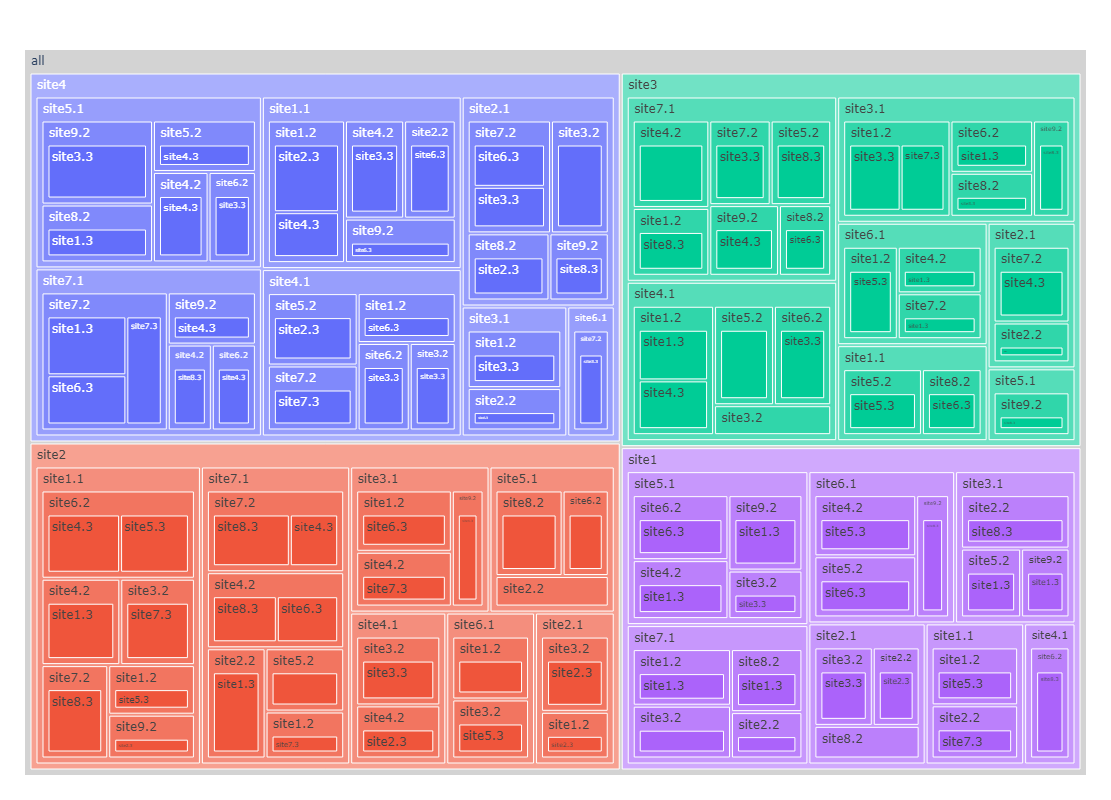

In [28]:
make_treemap(df_2025)

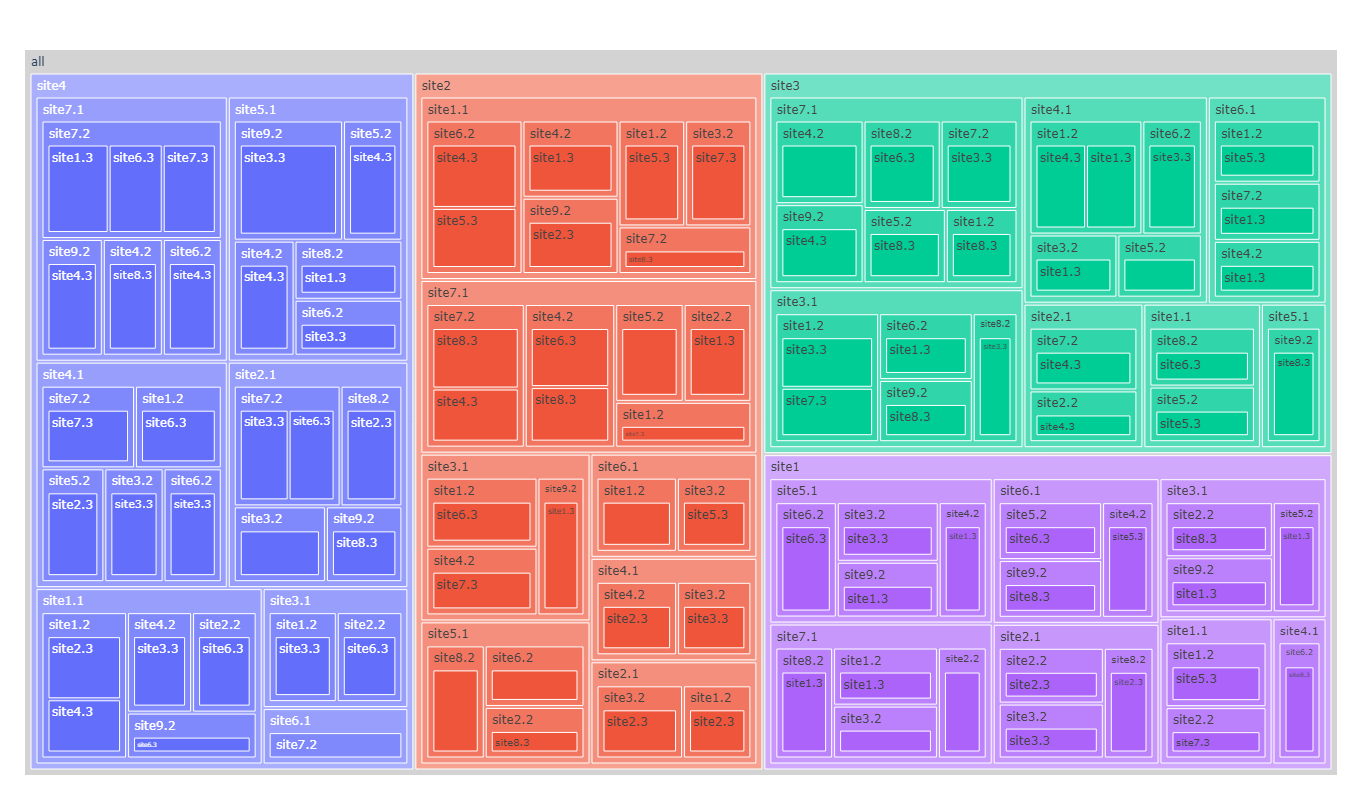

In [29]:
make_treemap(df_2025_2030)